
<table align="center">
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ogirimah/generative-ai-workshop/blob/main/workshop.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ogirimah/generative-ai-workshop/workshop.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

In [ ]:
!pip install snntorch

Matplotlib and Numpy are already installed in Google Colab. If you are running this notebook on your local machine, you may need to install them by uncommenting and running the following commands:

In [ ]:
# !pip install numpy matplotlib

# First training stage

This stage involves training the neurons to achieve resonance with the input data. The input data is a dataset of black and white images. The neurons are trained to respond to the black pixels in the images.

## Generate the dataset

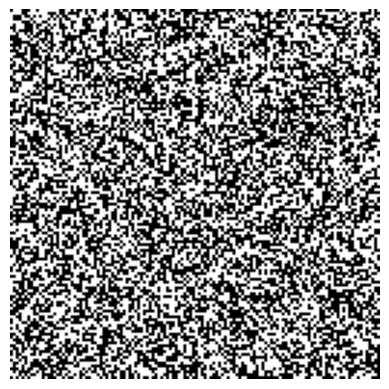

Dataset shape: (1024, 128, 128)


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Define image size
image_size = 128
num_images = 1024  # Number of images
num_columns = 10000  # Number of columns in the dataset

# Generate random indices for black pixels (same for all images)
num_pixels = image_size * image_size // 2
black_indices = np.random.choice(image_size * image_size, num_pixels, replace=False)

# Create an empty dataset
dataset = np.zeros((num_images, image_size, image_size), dtype=np.uint8)

# Set black pixels for each image
for i in range(num_images):
    dataset[i].flat[black_indices] = 255

# Display the first image (optional)
plt.imshow(dataset[0], cmap='gray')
plt.axis('off')
plt.show()

# Save the dataset (you can choose your preferred format, e.g., npy, h5, etc.)
# For example, saving as a NumPy binary file:
np.save('black_white_dataset.npy', dataset)

print(f"Dataset shape: {dataset.shape}")

## Model Dependency Imports

In [15]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

## Load the dataset

In [6]:
# Arguments for the dataloader
batch_size = 128
dtype = torch.float
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define a Transform to convert the dataset to a PyTorch Tensor and normalize the pixel values.

In [22]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((32, 32)), # Experiment with different image sizes
            transforms.Grayscale(),
            # transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# Load the dataset
dataset = np.load('./black_white_dataset.npy')

# Convert dataset to Pytorch Tensor
data_tensor = torch.tensor(dataset, dtype=dtype).unsqueeze(1)
# data_tensor = torch.from_numpy(dataset)
#Apply the transform
transformed_dataset = transform(data_tensor)

## Define the SNN model

### Define the network architecture

In [ ]:
# Network Architecture
num_inputs = 32*32
num_hidden = 1000
num_outputs = 2

# Temporal Dynamics
num_steps = 25
beta = 0.95

### Define the Network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #  Initialize layers
        self.fc1 = snn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.leak(beta=beta)
        self.fc2 = snn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.leak(beta=beta)

    def forward(self, x):
        
        # Initialize hidden states
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        
# Load the network onto CUDA if available
net = Net().to(device)